## Result 1: Slices Equivalence
BANKSY identified two subtypes in mature oligodendrocytes (MOD)  
- These were primarily shown at Bregma = 0.16 and 0.26 in their paper  
- The findings consistently appear across slices in similar regions  

In this project, the main goal is to examine if the two subtypes are truly distinct.   
However, this project is based on transcripts from a slice at Bregma -0.24. It's necessary to show the slices equivalence.  


In [21]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec

import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("../src"))
from plot import CM, _plot_scalebar

### data

#### Results of BANKSY

In [22]:
banksy_folder_path = Path("../data/banksy_results/")

In [ ]:
columns = ["Centroid_X", "Centroid_Y", "Bregma", "lam0.2"]

banksy_result = pd.read_csv(
        banksy_folder_path/"banksy_cluster.txt",
        usecols=columns,
        sep="\t"
    ).rename(
        columns={
            "Centroid_X": "x",
            "Centroid_Y": "y",
            "Bregma": "Bregma",
            "lam0.2": "banksy_cluster",
        }
    )

In [42]:
banksy_result

,Bregma,banksy_cluster,x,y
0,0.26,3,-3211.562145,2608.541476
1,0.26,2,-3207.923151,2621.795437
2,0.26,2,-3209.578004,2633.153494
3,0.26,2,-3203.853515,2756.045983
4,0.26,4,-3202.682705,2608.803635
...,...,...,...,...
64368,-0.29,8,2220.422637,-2538.615415
64369,-0.29,7,2136.112688,-2725.771187
64370,-0.29,9,2164.034469,-2531.472820
64371,-0.29,7,2238.056389,-2354.211194


In [43]:
columns = ["Centroid_X", "Centroid_Y", "Bregma", "clust_M0_lam0.2_k50_res0.5"]
banksy_result_all = pd.read_csv(
        banksy_folder_path/"banksy_result_all.txt",
        usecols=columns,
        sep="\t"
    ).rename(
        columns={
            "Centroid_X": "x",
            "Centroid_Y": "y",
            "Bregma": "Bregma",
            "clust_M0_lam0.2_k50_res0.5": "banksy_label",
        }
    )

In [44]:
banksy_result = banksy_result.merge(
    banksy_result_all[['x', 'y', 'banksy_label']],
    on=['x', 'y'],
    how='left'
)

banksy_result['match'] = banksy_result['banksy_cluster'] == banksy_result['banksy_label']
print(banksy_result[banksy_result['match'] == False])

       Bregma  banksy_cluster            x            y  banksy_label  match
20       0.26              11 -3154.404821  2745.502415             6  False
22       0.26              11 -3147.432675  2733.732002             6  False
24       0.26              11 -3124.976705  2731.151119             6  False
32       0.26              11 -3100.737635  2722.995641             6  False
47       0.26              11 -3148.882287  2743.548583             6  False
...       ...             ...          ...          ...           ...    ...
64341   -0.29               2  2043.160545 -3852.329010             4  False
64347   -0.29               2  2043.982884 -4010.806437             5  False
64349   -0.29              17  2180.520891 -3933.367933            12  False
64352   -0.29               1  2102.225337 -3726.744395             2  False
64355   -0.29               1  2072.154019 -3723.846543             2  False

[8456 rows x 6 columns]


#### Segmentation Dataset

In [24]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [25]:
merfish_data = pd.read_csv(MERFISH_data_folder_path / "merfish_all_cells.csv").rename(columns={"Centroid_X": "x", "Centroid_Y": "y"})

# Drop unwanted columns
merfish_data = merfish_data.drop(columns=[col for col in merfish_data.columns if col == 'Fos' or col.startswith('Blank_')])

# Filter data
merfish_data = merfish_data[merfish_data["Cell_class"] != "Ambiguous"]
merfish_data = merfish_data[merfish_data["Animal_ID"] == 1]

# Assign BankSY cluster (merge safer than indexing by order)
merfish_data = merfish_data.merge(
    banksy_result[["x", "y", "banksy_cluster"]],
    on=["x", "y"],
    how="left"
)
merfish_data = merfish_data.rename(columns={"banksy_cluster": "banksy"})

# Class mapping
cell_class_m = {
    'Astrocyte': 'Astrocyte',
    'Endothelial 1': 'Endothelial',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Ependymal': 'Ependymal',
    'Excitatory': 'Excitatory',
    'Inhibitory': 'Inhibitory',
    'Microglia': 'Microglia',
    'OD Immature 1': 'OD Immature',
    'OD Immature 2': 'OD Immature',
    'OD Mature 1': 'OD Mature',
    'OD Mature 2': 'OD Mature',
    'OD Mature 3': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes'
}

merfish_data["Cell_class"] = merfish_data["Cell_class"].map(cell_class_m).fillna("Other")
merfish_data = merfish_data.sort_values(by="Cell_class")

#### color map

In [26]:
color_map = {8: 'red', 7: 'orange'}

all_labels = banksy_result['banksy_cluster'].unique()
unique_other_labels = [label for label in all_labels if label not in color_map]
num_other_labels = len(unique_other_labels)
colormap = plt.get_cmap('tab20b', num_other_labels)
other_colors = {label: colormap(i) for i, label in enumerate(unique_other_labels)}

full_color_map = {**color_map, **other_colors}

In [27]:
all_labels = sorted(merfish_data['Cell_class'].unique())
colormap = plt.cm.get_cmap('tab20b', len(all_labels))
label_to_color = {label: colormap(i) for i, label in enumerate(all_labels)}
colors = merfish_data['Cell_class'].map(label_to_color)

C:\Users\tomo\AppData\Local\Temp\ipykernel_12148\3645616914.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20b', len(all_labels))


### Cell Types
Here, slices at Bregma = -0.24, 0.16, and 0.26 are compared to assess: 
- whether the same cell types appear across slices
- whether they occupy similar spatial regions

In [ ]:
# Bregma = -0.24
merfish_024 = merfish_data[merfish_data['Bregma'] == -0.24].copy()
merfish_024['x'] = merfish_024['x'] - merfish_024['x'].min()
merfish_024['y'] = merfish_024['y'] - merfish_024['y'].min()

# Bregma = 0.16
merfish_016 = merfish_data[merfish_data['Bregma'] == 0.16].copy()
merfish_016['x'] = merfish_016['x'] - merfish_016['x'].min()
merfish_016['y'] = merfish_016['y'] - merfish_016['y'].min()

# Bregma = 0.26
merfish_026 = merfish_data[merfish_data['Bregma'] == 0.26].copy()
merfish_026['x'] = merfish_026['x'] - merfish_026['x'].min()
merfish_026['y'] = merfish_026['y'] - merfish_026['y'].min()

# Stacked Bar Plot
# Used to compare cell type proportions across slices, as part of the equivalence analysis.
merfish_barplot = merfish_data[(merfish_data['Bregma'] == 0.26) | (merfish_data['Bregma'] == 0.16) | (merfish_data['Bregma'] == -0.24)].copy()
df_counts = merfish_barplot.groupby(["Bregma", "Cell_class"]).size().unstack(fill_value=0)
df_normalized = df_counts.div(df_counts.sum(axis=1), axis=0)
df_normalized = df_normalized.sort_index(ascending=False)

C:\Users\tomo\AppData\Local\Temp\ipykernel_12148\795187041.py:70: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("../data/results/R1/celltypes.pdf", bbox_inches='tight')
C:\Users\tomo\AppData\Local\Temp\ipykernel_12148\795187041.py:70: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("../data/results/R1/celltypes.pdf", bbox_inches='tight')
d:\miniconda\envs\ovrlpy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


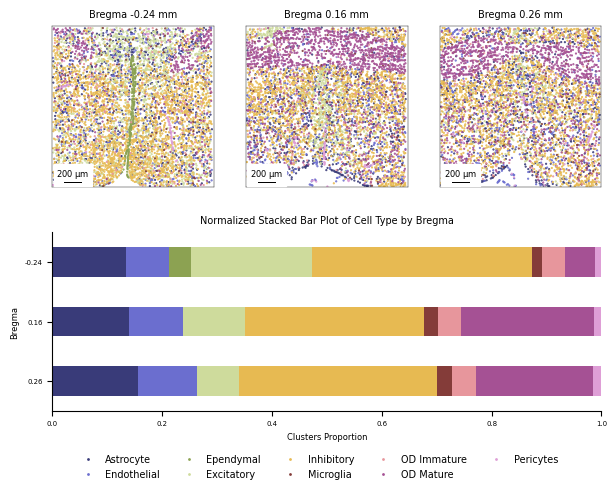

In [12]:
fig = plt.figure(figsize=(18*CM, 13*CM), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

scatter_data = [
    (merfish_024, "Bregma -0.24 mm"),
    (merfish_016, "Bregma 0.16 mm"),
    (merfish_026, "Bregma 0.26 mm")
]

axes_scatter = []

for i, (df, title) in enumerate(scatter_data):
    ax = fig.add_subplot(gs[0, i])
    ax.scatter(
        df["x"], df["y"],
        s=0.3,
        c=df['Cell_class'].map(label_to_color),
        rasterized=True
    )
    ax.set_title(title, fontsize=7)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-10, 1810)
    ax.set_ylim(-10, 1810)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_linewidth(0.3)
    _plot_scalebar(ax, dx=1, units="um", location="lower left", length_fraction=0.2, fontsize=6, box_alpha=1, color="black")
    axes_scatter.append(ax)

# Add bar plot
ax4 = fig.add_subplot(gs[1, :])
df_normalized.plot(
    kind="barh", stacked=True, ax=ax4,
    color=[label_to_color.get(label) for label in df_normalized.columns]
)

ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.set_xlim(0, 1)
ax4.get_legend().remove()
ax4.tick_params(axis='x', labelsize=5)
ax4.tick_params(axis='y', labelsize=5)
ax4.set_xlabel("Clusters Proportion", fontsize=6)
ax4.set_ylabel("Bregma", fontsize=6)
ax4.set_title("Normalized Stacked Bar Plot of Cell Type by Bregma", fontsize=7)

# Global legend
handles = [
    mlines.Line2D(
        [0], [0], marker='.', linestyle='None',
        color='none',
        markerfacecolor=label_to_color[label],
        markeredgecolor='none',
        markersize=4,
        label=label
    )
    for label in all_labels
]

fig.legend(
    handles=handles,
    fontsize=7,
    loc='lower center',
    frameon=False,
    bbox_to_anchor=(0.5, -0.04),
    ncol=5
)

plt.savefig("../data/results/R1/celltypes.pdf", bbox_inches='tight')
plt.show()


### UMAP
UMAP embeddings from BANKSY is used to visually compare clustering consistency across slices.  

In [28]:
all_UMAP = pd.read_csv(banksy_folder_path / 'umap.csv', sep = ',')
all_UMAP.loc[:, 'banksy'] = banksy_result['banksy_cluster'].values

In [29]:
B24_ids = pd.read_csv(banksy_folder_path / 'umap_B24.csv', sep = ',')
B24_ids['Cell_id'] = "Animal_1_" + B24_ids['cell_ids']
B24_UMAP = all_UMAP[all_UMAP['Cell_id'].isin(B24_ids['Cell_id'])]

In [30]:
B16_UMAP = pd.read_csv(banksy_folder_path / 'umap_B16.csv', sep = ',')
banksy_016 = banksy_result[banksy_result['Bregma'] == 0.16].copy()
B16_UMAP.loc[:, 'banksy'] = banksy_016['banksy_cluster'].values

In [31]:
B26_UMAP = pd.read_csv(banksy_folder_path / 'umap_B26.csv', sep = ',')
banksy_026 = banksy_result[banksy_result['Bregma'] == 0.26].copy()
B26_UMAP.loc[:, 'banksy'] = banksy_026['banksy_cluster'].values

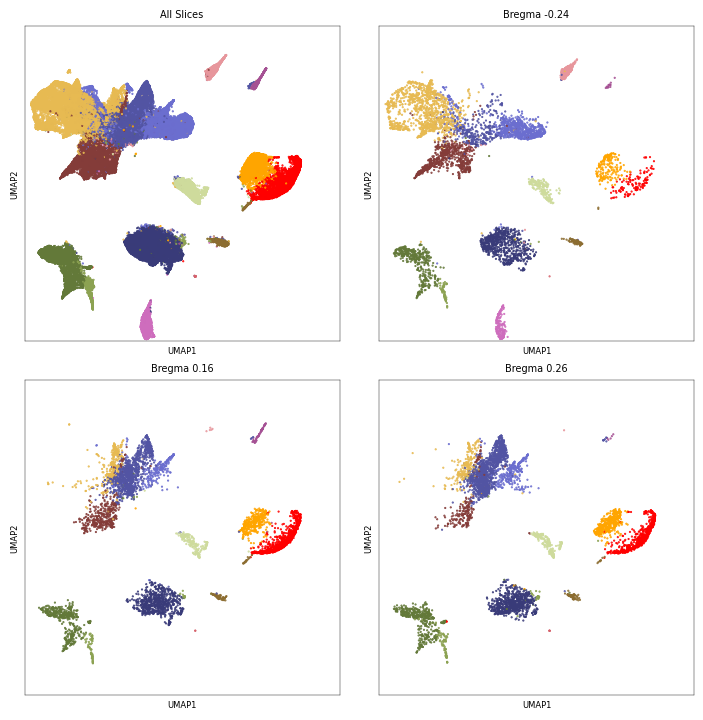

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(18*CM, 18*CM), sharex=True, sharey=True, constrained_layout=True)
ax = ax.flatten()

titles = ["All Slices", "Bregma -0.24", "Bregma 0.16", "Bregma 0.26"]
datasets = [all_UMAP, B24_UMAP, B16_UMAP, B26_UMAP]

for i, (a, df) in enumerate(zip(ax, datasets)):
    a.scatter(df['UMAP_1'], df['UMAP_2'], s=0.3, c=df['banksy'].map(full_color_map), rasterized=True)
    a.set_title(titles[i], fontsize=7)
    a.set_aspect('equal', adjustable='box')
    a.set_xlim(-20, 35)
    a.set_ylim(-30, 25)
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("UMAP1", fontsize=6)
    a.set_ylabel("UMAP2", fontsize=6)
    a.xaxis.set_tick_params(labelsize=5, width=0.3)
    a.yaxis.set_tick_params(labelsize=5, width=0.3)
    a.spines[["top", "right", "left", "bottom"]].set_linewidth(0.3)

plt.savefig("../data/results/R1/UMAP.pdf", bbox_inches='tight')
plt.show()


### MOD Distribution
MOD subtypes are identified in all slices and localize to similar regions, supporting spatial and compositional equivalence across slices.


In [18]:
color_map = {7: 'orange', 8: 'red'}

In [19]:
banksy_024 = banksy_result[banksy_result['Bregma']==-0.24].copy()
banksy_024_MOD = banksy_024[(banksy_024['banksy_cluster'] == 7) | (banksy_024['banksy_cluster'] == 8)].copy()
banksy_024_MOD['x'] = banksy_024_MOD['x'] - banksy_024_MOD['x'].min()
banksy_024_MOD['y'] = banksy_024_MOD['y'] - banksy_024_MOD['y'].min()
banksy_024_MOD = banksy_024_MOD.copy()

banksy_016_MOD = banksy_016[(banksy_016['banksy_cluster'] == 7) | (banksy_016['banksy_cluster'] == 8)].copy()
banksy_016_MOD['x'] = banksy_016_MOD['x'] - banksy_016_MOD['x'].min()
banksy_016_MOD['y'] = banksy_016_MOD['y'] - banksy_016_MOD['y'].min()
banksy_016_MOD = banksy_016_MOD.copy()

banksy_026_MOD = banksy_026[(banksy_026['banksy_cluster'] == 7) | (banksy_026['banksy_cluster'] == 8)].copy()
banksy_026_MOD['x'] = banksy_026_MOD['x'] - banksy_026_MOD['x'].min()
banksy_026_MOD['y'] = banksy_026_MOD['y'] - banksy_026_MOD['y'].min()
banksy_026_MOD = banksy_026_MOD.copy()

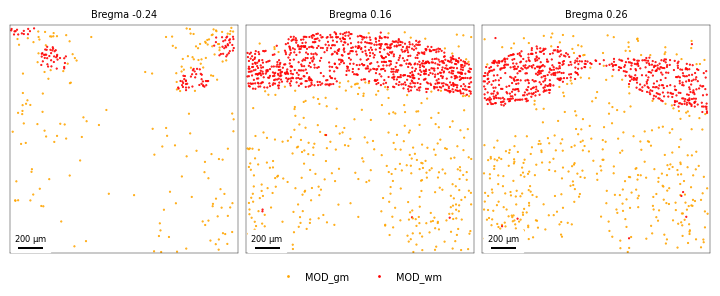

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18*CM, 7*CM), sharex=True, sharey=True, constrained_layout=True)

titles = ["Bregma -0.24", "Bregma 0.16", "Bregma 0.26"]
datasets = [banksy_024_MOD, banksy_016_MOD, banksy_026_MOD]

for i, (a, df) in enumerate(zip(ax, datasets)):
    a.scatter(df['x'], df['y'], s=0.3, c=df['banksy_cluster'].map(color_map), rasterized=True)
    a.set_title(titles[i], fontsize=7)
    a.set_aspect('equal', adjustable='box')
    a.set_xlim(-10, 1810)
    a.set_ylim(-10, 1810)
    a.set_xticks([])
    a.set_yticks([])
    a.xaxis.set_tick_params(labelsize=5, width=0.3)
    a.yaxis.set_tick_params(labelsize=5, width=0.3)
    a.spines[["top", "right", "left", "bottom"]].set_linewidth(0.3)
    _plot_scalebar(a, dx=1, units="um", location="lower left", length_fraction=0.2, fontsize=6, box_alpha=1, color="black")

# Global legend
label_display_map = {
    7: 'MOD_gm',
    8: 'MOD_wm'
}

handles = [
    mlines.Line2D(
        [0], [0], marker='.', linestyle='None',
        color='none',
        markerfacecolor=color_map[label],
        markeredgecolor='none',
        markersize=4,
        label=label_display_map[label]
    )
    for label in [7, 8]
]

fig.legend(
    handles=handles,
    fontsize=7,
    loc='lower center',
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    ncol=2
)

plt.savefig("../data/results/R1/MOD.pdf", bbox_inches='tight')
plt.show()